In [1]:
%env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


# Yes, Transformers are Effective for Time Series Forecasting

## Introduction

A few months ago, we introduced the [Informer](https://huggingface.co/blog/informer) model ([Zhou, Haoyi, et al., 2021](https://arxiv.org/abs/2012.07436)), which is a Time Series Transformer that won the AAAI 2021 best paper award. We also provided an example for multivariate probabilistic forecasting with Informer. In this post, we introduce the _Autoformer_ model ([Wu, Haixu, et al., 2021](https://arxiv.org/abs/2106.13008)), which was published in NeurIPS 2021 after the Informer model. The Autoformer model is [now available](https://huggingface.co/docs/transformers/main/en/model_doc/autoformer) in 🤗 Transformers.

We will begin by explaining the Autoformer model, including its novel _Decomposition Layer_ and _Attention (Autocorrelation) Mechanism_. Next, we will present the _DLinear_ model, which is a simple feedforward network that uses the decomposition layer from Autoformer. The DLinear model was first introduced in [Are Transformers Effective for Time Series Forecasting?](https://arxiv.org/abs/2205.13504) which published recently in AAAI 2023. Finally, we will provide empirical evidence that **Transformers are indeed Effective for Time Series Forecasting**. Our comparison shows that a simple linear model is not better than Transformers, as claimed. (Kashif - maybe this sentence can be rephrased to something less controversial?)

## Autoformer - Under The Hood

The Autoformer builds upon the traditional method of decomposing time series into seasonality and trend-cycle components. This is achieved through the incorporation of a _Decomposition Layer_, which enhances the model's ability to capture these components accurately. Moreover, the Autoformer introduces an innovative auto-correlation mechanism that replaces the standard self-attention used in the vanilla transformer. This mechanism enables the model to utilize period-based dependencies in the attention, thus improving the overall performence. 

In the upcoming sections, we will delve into the two key contributions of the Autoformer: the _Decomposition Layer_ and the _Attention (Autocorrelation) Mechanism_. We will also provide code examples to illustrate how these components function within the Autoformer architecture.

### Decomposition Layer
Decomposition has long been a popular method in time series analysis, but it had not been extensively incorporated into deep learning models until the introduction of the Autoformer paper. In the upcoming sections, we will introduce the general decomposition concept in time series analysis. Following that, we will demonstrate how this idea is applied in Autoformer using PyTorch code.

####  Decomposition of Time Series
In time series analysis, [decomposition](https://en.wikipedia.org/wiki/Decomposition_of_time_series) is a method of breaking down a time series into three systematic components, including trend-cycle, seasonal variation, and random fluctuations.
The trend component represents the long-term direction of the time series, which can be increasing, decreasing, or stable over time. The seasonal component represents the recurring patterns that occur within the time series, such as yearly or quarterly cycles. Finally, the random (sometimes called "irregular") component represents the random noise in the data that cannot be explained by the trend or seasonal components. 

Two main types of decomposition are additive and multiplicative decomposition, which implemented in the [great statsmodels library](https://www.statsmodels.org/dev/generated/statsmodels.tsa.seasonal.seasonal_decompose.html). By decomposing a time series into these components, we can better understand and model the underlying patterns in the data. 

But how can we incorporate decomposition into the transformer architecture? Let's see how Autoformer do it.

#### Decomposition in Autoformer

| ![autoformer_architecture](images/autoformer_architecture.png) |
|:--:|
| Autoformer architecture from [the paper](https://arxiv.org/abs/2106.13008) |

Autoformer incorporates a decomposition block as an inner operation of the model, as presented in the Autoformer's architecture above. As can be seen, the encoder and decoder use a decomposition block to aggregate the trend-cyclical part and extract the seasonal part from series progressively. The concept of inner decomposition has demonstrated its usefulness since the publication of Autoformer. Subsequently, it has been adopted in several other time series papers, such as FEDformer ([Zhou, Tian, et al., ICML 2022](https://arxiv.org/abs/2201.12740)) and DLinear [(Zeng, Ailing, et al., AAAI 2023)](https://arxiv.org/abs/2205.13504), highlighting its significance in time series modeling.

Now, let's define the decomposition layer formally:

For an input series $\mathcal{X} \in \mathbb{R}^{L \times d}$ with length $L$, the decomposition layer returns $\mathcal{X}_\textrm{trend}, \mathcal{X}_\textrm{seasonal}$ defined as:

$$
\mathcal{X}_\textrm{trend} = \textrm{AvgPool(Padding(} \mathcal{X} \textrm{))} \\
\mathcal{X}_\textrm{seasonal} = \mathcal{X} - \mathcal{X}_\textrm{trend}
$$

And the implementation in PyTorch:
```python
import torch
from torch import nn

class DecompositionLayer(nn.Module):
    """
    Returns the trend and the seasonal parts of the time series.
    """

    def __init__(self, kernel_size):
        super().__init__()
        self.kernel_size = kernel_size
        self.avg = nn.AvgPool1d(kernel_size=kernel_size, stride=1, padding=0) # moving average 

    def forward(self, x):
        """Input shape: Batch x Time x EMBED_DIM"""
        # padding on the both ends of time series
        num_of_pads = (self.kernel_size - 1) // 2
        front = x[:, 0:1, :].repeat(1, num_of_pads, 1)
        end = x[:, -1:, :].repeat(1, num_of_pads, 1)
        x_padded = torch.cat([front, x, end], dim=1)

        # calculate the trend and seasonal part of the series
        x_trend = self.avg(x_padded.permute(0, 2, 1)).permute(0, 2, 1)
        x_seasonal = x - x_trend
        return x_seasonal, x_trend
```

As you can see, the implementation is quite simple and can be used in other models, as we will see with DLinear. Now, let's explain the second contribution - _Attention (Autocorrelation) Mechanism_.

### Attention (Autocorrelation) Mechanism

| ![autoformer_autocorrelation_vs_full_attention](images/autoformer_autocorrelation_vs_full_attention.png) |
|:--:|
|  Vanilla self attention vs Autocorrelation mechanism, from [the paper](https://arxiv.org/abs/2106.13008) |

In addition to the decomposition layer, Autoformer employs a novel auto-correlation mechanism which replaces the self-attention seamlessly. In the [vanilla time series transformer](https://huggingface.co/docs/transformers/model_doc/time_series_transformer), attention weights are computed in the time domain and point-wise aggregated. On the other hand, as can be seen in the figure above, in the auto-correlation mechanism they are computed in the frequency domain (using [fast fourier transform](https://en.wikipedia.org/wiki/Fast_Fourier_transform)) and aggregated by time delay. 

In the following sections, we will dive into these topics in detail and explain them with code examples.

####  Frequency Domain Attention 

| ![autoformer_autocorrelation_only_attention](images/autoformer_autocorrelation_only_attention.png) |
|:--:|
| Attention weights computation in frequency domain using FFT, from [the paper](https://arxiv.org/abs/2106.13008) |

In theory, given a time lag $\tau$, _autocorrelation_ for a single discrete variable $y$ is used to measure the "relationship" (pearson correlation) between the variable's current value at time $t$ to its past value at time $t-\tau$:

$$
\textrm{Autocorrelation}(\tau) = \textrm{Corr}(y_t, y_{t-\tau})
$$

Using autocorrelation, Autoformer extracts period-based dependencies from the queries and keys along with element-wise multiplication, instead of the standard dot-product between them (Kashif - Maybe it can be written better). You can think about it as a replacement for the $QK^T$ term in the self-attention.

In practice, autocorrelation of the queries and keys for **all lags** is calculated at once by FFT. By doing so, the autocorrelation mechanism achives $O(L \log L)$ time complexity ($L$ is the input time length), similar to [Informer's ProbSparse attention](https://huggingface.co/blog/informer#probsparse-attention). Note that the theory behind computing autocorrelation using FFT is based on the [Wiener–Khinchin theorem](https://en.wikipedia.org/wiki/Wiener%E2%80%93Khinchin_theorem), which we will not discuss here. (Kashif - maybe we can think about how to write this sentence more positively? hahaha)

Now, we are ready to see the code in PyTorch: 

```python
import torch 

def autocorrelation(query_states, key_states):
    """
    Computes autocorrelation(Q,K) using `torch.fft`. 
    Think about it as a replacement for the QK^T in the self-attention.
    
    Assumption: states are resized to same shape of [batch_size, time_length, embedding_dim].
    """
    query_states_fft = torch.fft.rfft(query_states, dim=1)
    key_states_fft = torch.fft.rfft(key_states, dim=1)
    attn_weights = query_states_fft * torch.conj(key_states_fft)
    attn_weights = torch.fft.irfft(attn_weights, dim=1)  
    
    return attn_weights
```

Quite simple! 😎 Please be aware that this is only a partial implementation of `autocorrelation(Q,K)`, and the full implementation can be found in 🤗 Transformers.

Next, we will see how to aggregate our `attn_weights` with the values by time delay, which termed as _Time Delay Aggregation_.

#### Time Delay Aggregation
| ![autoformer_autocorrelation_only_aggregation](images/autoformer_autocorrelation_only_aggregation.png) |
|:--:|
| Aggregation by time delay, from [the paper](https://arxiv.org/abs/2106.13008) |

Let's consider the autocorrelations (referred to as `attn_weights`) as $\mathcal{R_{Q,K}}$. The question arises: how do we aggregate these $\mathcal{R_{Q,K}}(\tau_1), \mathcal{R_{Q,K}}(\tau_2), ..., \mathcal{R_{Q,K}}(\tau_k)$ with $\mathcal{V}$? In the standard self-attention mechanism, this aggregation is accomplished through dot-product. However, in Autoformer, we employ a different approach. Firstly, we align $\mathcal{V}$ by calculating its value for each time delay $\tau_1, \tau_2, ... \tau_k$, which is also known as _Rolling_. Subsequently, we conduct element-wise multiplication between the aligned $\mathcal{V}$ and the autocorrelations. In the provided figure, you can observe the left side showcasing the rolling of $\mathcal{V}$ by time delay, while the right side illustrates the element-wise multiplication with the autocorrelations.

It can be summarized with the following equations:

$$
\tau_1, \tau_2, ... \tau_k = \textrm{arg Top-k}(\mathcal{R_{Q,K}}(\tau)) \\
\hat{\mathcal{R}}\mathcal{_{Q,K}}(\tau _1), \hat{\mathcal{R}}\mathcal{_{Q,K}}(\tau _2), ..., \hat{\mathcal{R}}\mathcal{_{Q,K}}(\tau _k) = \textrm{Softmax}(\mathcal{R_{Q,K}}(\tau _1), \mathcal{R_{Q,K}}(\tau_2), ..., \mathcal{R_{Q,K}}(\tau_k)) \\
\textrm{Autocorrelation-Attention} = \sum_{i=1}^k \textrm{Roll}(\mathcal{V}, \tau_i) \cdot \hat{\mathcal{R}}\mathcal{_{Q,K}}(\tau _i)
$$

And that's it! Note that $k$ is controlled by a hyperparameter called `autocorrelation_factor` (similar to `sampling_factor` in [Informer](https://huggingface.co/blog/informer)), and softmax is applied to the autocorrelations before the multiplication.

Now, we are ready to see the final code:

```python
import torch
import math

def time_delay_aggregation(attn_weights, value_states, autocorrelation_factor=2):
    """
    Computes aggregation as value_states.roll(delay) * top_k_autocorrelations(delay).
    The final result is the autocorrelation-attention output.
    Think about it as a replacement of the dot-product between attn_weights and value states.
    
    The autocorrelation_factor is used to find top k autocorrelations delays.
    Assumption: value_states and attn_weights shape: [batch_size, time_length, embedding_dim]
    """
    bsz, num_heads, tgt_len, channel = ...
    time_length = value_states.size(1)
    autocorrelations = attn_weights.view(bsz, num_heads, tgt_len, channel)

    # find top k autocorrelations delays
    top_k = int(autocorrelation_factor * math.log(time_length))
    autocorrelations_mean = torch.mean(autocorrelations, dim=(1, -1))  # bsz x tgt_len
    top_k_autocorrelations, top_k_delays = torch.topk(autocorrelations_mean, top_k, dim=1)

    # apply softmax on the channel dim
    top_k_autocorrelations = torch.softmax(top_k_autocorrelations, dim=-1)  # bsz x top_k

    # compute aggregation: value_states.roll(delay) * top_k_autocorrelations(delay)
    delays_agg = torch.zeros_like(value_states).float()  # bsz x time_length x channel
    for i in range(top_k):
        value_states_roll_delay = value_states.roll(shifts=-int(top_k_delays[i]), dims=1)
        top_k_at_delay = top_k_autocorrelations[:, i]
        # aggregation
        top_k_resized = top_k_at_delay.view(-1, 1, 1).repeat(num_heads, tgt_len, channel)
        delays_agg += value_states_roll_delay * top_k_resized

    attn_output = delays_agg.contiguous()
    return attn_output
```
   
We did it! The Autoformer model in [now available](https://huggingface.co/docs/transformers/main/en/model_doc/autoformer) in the 🤗 Transformers library, and simply called `AutoformerModel`.

Our strategy with this model is to show the performance of the univariate model, then a multivariate model and compare it to the inheriently univariate D-Linear model.

(Now I'm thinking about the next section. We can show comparison on one dataset (e.g. traffic) and say that in multivariate settings transformers are bad as we already saw in Informer)

## D-Linear 

D-Linear  model first calculates the moving average (or trend) of the incoming signal using a certain kernel size and decomposes the signal into the residual (the seasonality) and trend via:

```python
class SeriesDecomp(nn.Module):
    def __init__(self, kernel_size):
        super().__init__()
        self.moving_avg = MovingAvg(kernel_size, stride=1)

    def forward(self, x):
        moving_mean = self.moving_avg(x)
        res = x - moving_mean
        return res, moving_mean
```

Then two linear layers are deployed which in the point forecasting case project the context length array to a prediction length array for the seosonal and trend part and the resulting output is added together as the final prediction. In the probabistic setting one can project the context length arrays to a `prediction-length * hidden` dim and then the resulting outputs are reshaped to `(prediction_length, hidden)`. Then a probabistic head maps the latent representations of size `hidden` to the parameters of some distribution.

For our benchmark, we will use the implementation of D-Linear from GluonTS.



## Benchmarking - Autoformer vs. DLinear (WIP)

We now show empirical evidence that Transformers are Effective for Time Series Forecasting, by benchmarking on nine widely-used real-world datasets which used in Autoformer and DLinear papers. These datasets including ETT (Electricity Transformer Temperature) [30] (ETTh1, ETTh2, ETTm1, ETTm2), Traffic, Electricity, Weather, ILI, Exchange-Rate [15]. 

All of them are multivariate time series.

TODO: validate HF datasets have the same stats like in the table

| ![autoformer_datasets_stats](images/autoformer_datasets_stats.png) |
|:--:|
| Forcasting Datasets Statistics , from [DLinear paper](https://arxiv.org/abs/2205.13504) |
From DLinear paper:

1. "In summary, these results reveal that existing complex Transformer-based LTSF solutions are not seemingly effective on the existing nine benchmarks while LTSF-Linear can be a powerful baseline."



## Datasets Information
ETT (Electricity Transformer Temperature) [30]2 consists
of two hourly-level datasets (ETTh) and two 15-
minute-level datasets (ETTm). Each of them contains
seven oil and load features of electricity transformers
from July 2016 to July 2018.
• Traffic3 describes the road occupancy rates. It contains
the hourly data recorded by the sensors of San
Francisco freeways from 2015 to 2016.
• Electricity4 collects the hourly electricity consumption
of 321 clients from 2012 to 2014.
• Exchange-Rate [15]5 collects the daily exchange rates
of 8 countries from 1990 to 2016.
• Weather6 includes 21 indicators of weather, such as air
temperature, and humidity. Its data is recorded every
10 min for 2020 in Germany.
• ILI7 describes the ratio of patients seen with influenzalike
illness and the number of patients. It includes
weekly data from the Centers for Disease Control and
Prevention of the United States from 2002 to 2021.

## Set-up Environment

First, let's install the necessary libraries: 🤗 Transformers, 🤗 Datasets, 🤗 Evaluate, 🤗 Accelerate and [GluonTS](https://github.com/awslabs/gluonts).

As we will show, GluonTS will be used for transforming the data to create features as well as for creating appropriate training, validation and test batches.

In [1]:
%pip install -q git+https://github.com/huggingface/transformers.git datasets evaluate accelerate gluonts ujson

We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [1]:
from transformers.utils import send_example_telemetry

send_example_telemetry("autoformer_notebook", framework="pytorch")

## Load Dataset

In this blog post, we'll use the `traffic_hourly` dataset, which is available on the [Hugging Face Hub](https://huggingface.co/datasets/monash_tsf). This dataset contains the San Francisco Traffic dataset used by [Lai et al. (2017)](https://arxiv.org/abs/1703.07015). It contains 862 hourly time series showing the road occupancy rates in the range $[0, 1]$ on the San Francisco Bay area freeways from 2015 to 2016.

This dataset is part of the [Monash Time Series Forecasting](https://forecastingdata.org/) repository, a collection of time series datasets from a number of domains. It can be viewed as the [GLUE benchmark](https://gluebenchmark.com/) of time series forecasting.

In [2]:
from gluonts.dataset.repository.datasets import get_dataset

dataset = get_dataset("traffic")

As can be seen, the dataset contains 3 splits: train, validation and test.

In [3]:
dataset.metadata

MetaData(freq='H', target=None, feat_static_cat=[CategoricalFeatureInfo(name='feat_static_cat_0', cardinality='862')], feat_static_real=[], feat_dynamic_real=[], feat_dynamic_cat=[], prediction_length=24)

Each example contains a few keys, of which `start` and `target` are the most important ones. Let us have a look at the first time series in the dataset:

In [4]:
train_example = next(iter(dataset.train))
train_example.keys()

dict_keys(['target', 'start', 'feat_static_cat', 'item_id'])

The `start` simply indicates the start of the time series (as a datetime), and the `target` contains the actual values of the time series.

The `start` will be useful to add time related features to the time series values, as extra input to the model (such as "month of year"). Since we know the frequency of the data is `hourly`, we know for instance that the second value has the timestamp `2015-01-01 01:00:01`, `2015-01-01 02:00:01`, etc.

In [5]:
print(train_example["start"])
print(len(train_example["target"]))

2015-01-01 00:00
14036


The validation set contains the same data as the training set, just for a `prediction_length` longer amount of time. This allows us to validate the model's predictions against the ground truth.

The test set is again one `prediction_length` longer data compared to the validation set (or some multiple of  `prediction_length` longer data compared to the training set for testing on multiple rolling windows).

In [6]:
test_example = next(iter(dataset.test))
test_example.keys()

dict_keys(['target', 'start', 'feat_static_cat', 'item_id'])

The initial values are exactly the same as the corresponding training example. However, this example has `prediction_length=48` (48 hours, or 2 days) additional values compared to the training example. Let us verify it.

In [7]:
freq = dataset.metadata.freq
prediction_length = dataset.metadata.prediction_length

assert len(train_example["target"]) + prediction_length == len(
    test_example["target"]
)

Let's visualize this:

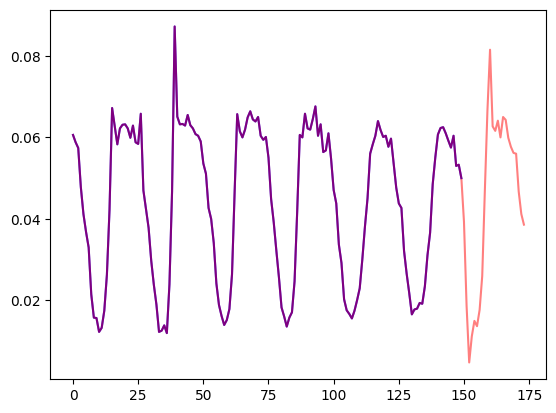

In [8]:
import matplotlib.pyplot as plt

num_of_samples = 150

figure, axes = plt.subplots()
axes.plot(train_example["target"][-num_of_samples:], color="blue")
axes.plot(
    test_example["target"][-num_of_samples - prediction_length :],
    color="red",
    alpha=0.5,
)

plt.show()

Let's split up the data:

In [9]:
train_dataset = dataset.train
test_dataset = dataset.test

## Define the model

Next, let's instantiate a model. The model will be trained from scratch, hence we won't use the `from_pretrained` method here, but rather randomly initialize the model from a [`config`](https://huggingface.co/docs/transformers/main/en/model_doc/informer#transformers.InformerConfig).

We specify a couple of additional parameters to the model:
- `prediction_length` (in our case, `48` hours): this is the horizon that the decoder of the Informer will learn to predict for;
- `context_length`: the model will set the `context_length` (input of the encoder) equal to the `prediction_length`, if no `context_length` is specified;
- `lags` for a given frequency: these specify an efficient "look back" mechanism, where we concatenate values from the past to the current values as additional features, e.g. for a `Daily` frequency we might consider a look back of `[1, 7, 30, ...]` or for `Minute` data we might consider `[1, 30, 60, 60*24, ...]` etc.;
- the number of time features: in our case, this will be `5` as we'll add `HourOfDay`, `DayOfWeek`, ..., and `Age` features (see below).

Let us check the default lags provided by GluonTS for the given frequency ("hourly"):

In [10]:
from gluonts.time_feature import get_lags_for_frequency

lags_sequence = get_lags_for_frequency(freq)
print(lags_sequence)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


In [11]:
from gluonts.time_feature import time_features_from_frequency_str

time_features = time_features_from_frequency_str(freq)
print(time_features)

[<function hour_of_day at 0x11ffc4700>, <function day_of_week at 0x11ffc4820>, <function day_of_month at 0x11ffc4940>, <function day_of_year at 0x11ffc4a60>]


In this case, there are four additional features, namely "hour of day", "day of week", "day of month" and "day of year". This means that for each time step, we'll add these features as a scalar values. For example, consider the timestamp `2015-01-01 01:00:01`. The four additional features will be:

In [12]:
from transformers import AutoformerConfig, AutoformerForPrediction

config = AutoformerConfig(
    # in the multivariate setting, input_size is the number of variates in the time series per time step
    input_size=1,
    # prediction length:
    prediction_length=prediction_length,
    # context length:
    context_length=prediction_length,
    # lags value copied from 1 week before:
    lags_sequence=lags_sequence,
    # we'll add 5 time features ("hour_of_day", ..., and "age"):
    num_time_features=len(time_features) + 1,
    # informer params:
    dropout=0.1,
    encoder_layers=1,
    decoder_layers=1,
    # project input from num_of_variates*len(lags_sequence)+num_time_features to:
    d_model=32,
)

model = AutoformerForPrediction(config)

By default, the model uses a diagonal Student-t distribution (but this is [configurable](https://huggingface.co/docs/transformers/main/en/internal/time_series_utils)):

In [13]:
model.config.distribution_output

'student_t'

## Define Transformations

Next, we define the transformations for the data, in particular for the creation of the time features (based on the dataset or universal ones).

Again, we'll use the GluonTS library for this. We define a `Chain` of transformations (which is a bit comparable to `torchvision.transforms.Compose` for images). It allows us to combine several transformations into a single pipeline.

In [14]:
from gluonts.time_feature import TimeFeature
from gluonts.dataset.field_names import FieldName
from gluonts.transform import (
    AddAgeFeature,
    AddObservedValuesIndicator,
    AddTimeFeatures,
    AsNumpyArray,
    Chain,
    ExpectedNumInstanceSampler,
    InstanceSplitter,
    RemoveFields,
    SelectFields,
    SetField,
    TestSplitSampler,
    Transformation,
    ValidationSplitSampler,
    VstackFeatures,
    RenameFields,
)

The transformations below are annotated with comments, to explain what they do. At a high level, we will iterate over the individual time series of our dataset and add/remove fields or features:

In [15]:
from transformers import PretrainedConfig


def create_transformation(freq: str, config: PretrainedConfig) -> Transformation:
    # create list of fields to remove later
    remove_field_names = []
    if config.num_static_real_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_REAL)
    if config.num_dynamic_real_features == 0:
        remove_field_names.append(FieldName.FEAT_DYNAMIC_REAL)
    if config.num_static_categorical_features == 0:
        remove_field_names.append(FieldName.FEAT_STATIC_CAT)

    return Chain(
        # step 1: remove static/dynamic fields if not specified
        [RemoveFields(field_names=remove_field_names)]
        # step 2: convert the data to NumPy (potentially not needed)
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_CAT,
                    expected_ndim=1,
                    dtype=int,
                )
            ]
            if config.num_static_categorical_features > 0
            else []
        )
        + (
            [
                AsNumpyArray(
                    field=FieldName.FEAT_STATIC_REAL,
                    expected_ndim=1,
                )
            ]
            if config.num_static_real_features > 0
            else []
        )
        + [
            AsNumpyArray(
                field=FieldName.TARGET,
                # we expect an extra dim for the multivariate case:
                expected_ndim=1 if config.input_size == 1 else 2,
            ),
            # step 3: handle the NaN's by filling in the target with zero
            # and return the mask (which is in the observed values)
            # true for observed values, false for nan's
            # the decoder uses this mask (no loss is incurred for unobserved values)
            # see loss_weights inside the xxxForPrediction model
            AddObservedValuesIndicator(
                target_field=FieldName.TARGET,
                output_field=FieldName.OBSERVED_VALUES,
            ),
            # step 4: add temporal features based on freq of the dataset
            # these serve as positional encodings
            AddTimeFeatures(
                start_field=FieldName.START,
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_TIME,
                time_features=time_features_from_frequency_str(freq),
                pred_length=config.prediction_length,
            ),
            # step 5: add another temporal feature (just a single number)
            # tells the model where in the life the value of the time series is
            # sort of running counter
            AddAgeFeature(
                target_field=FieldName.TARGET,
                output_field=FieldName.FEAT_AGE,
                pred_length=config.prediction_length,
                log_scale=True,
            ),
            # step 6: vertically stack all the temporal features into the key FEAT_TIME
            VstackFeatures(
                output_field=FieldName.FEAT_TIME,
                input_fields=[FieldName.FEAT_TIME, FieldName.FEAT_AGE]
                + (
                    [FieldName.FEAT_DYNAMIC_REAL]
                    if config.num_dynamic_real_features > 0
                    else []
                ),
            ),
            # step 7: rename to match HuggingFace names
            RenameFields(
                mapping={
                    FieldName.FEAT_STATIC_CAT: "static_categorical_features",
                    FieldName.FEAT_STATIC_REAL: "static_real_features",
                    FieldName.FEAT_TIME: "time_features",
                    FieldName.TARGET: "values",
                    FieldName.OBSERVED_VALUES: "observed_mask",
                }
            ),
        ]
    )

## Define `InstanceSplitter`

For training/validation/testing we next create an `InstanceSplitter` which is used to sample windows from the dataset (as, remember, we can't pass the entire history of values to the model due to time- and memory constraints).

The instance splitter samples random `context_length` sized and subsequent `prediction_length` sized windows from the data, and appends a `past_` or `future_` key to any temporal keys for the respective windows. This makes sure that the `values` will be split into `past_values` and subsequent `future_values` keys, which will serve as the encoder and decoder inputs respectively. The same happens for any keys in the `time_series_fields` argument:

In [16]:
from gluonts.transform.sampler import InstanceSampler
from typing import Optional


def create_instance_splitter(
    config: PretrainedConfig,
    mode: str,
    train_sampler: Optional[InstanceSampler] = None,
    validation_sampler: Optional[InstanceSampler] = None,
) -> Transformation:
    assert mode in ["train", "validation", "test"]

    instance_sampler = {
        "train": train_sampler
        or ExpectedNumInstanceSampler(
            num_instances=1.0, min_future=config.prediction_length
        ),
        "validation": validation_sampler
        or ValidationSplitSampler(min_future=config.prediction_length),
        "test": TestSplitSampler(),
    }[mode]

    return InstanceSplitter(
        target_field="values",
        is_pad_field=FieldName.IS_PAD,
        start_field=FieldName.START,
        forecast_start_field=FieldName.FORECAST_START,
        instance_sampler=instance_sampler,
        past_length=config.context_length + max(config.lags_sequence),
        future_length=config.prediction_length,
        time_series_fields=["time_features", "observed_mask"],
    )

## Create PyTorch DataLoaders

Next, it's time to create PyTorch DataLoaders, which allow us to have batches of (input, output) pairs - or in other words (`past_values`, `future_values`).

In [17]:
from typing import Iterable

import torch
from gluonts.itertools import Cyclic, Cached
from gluonts.dataset.loader import as_stacked_batches


def create_train_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    num_batches_per_epoch: int,
    shuffle_buffer_length: Optional[int] = None,
    cache_data: bool = True,
    **kwargs,
) -> Iterable:
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    TRAINING_INPUT_NAMES = PREDICTION_INPUT_NAMES + [
        "future_values",
        "future_observed_mask",
    ]

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=True)
    if cache_data:
        transformed_data = Cached(transformed_data)

    # we initialize a Training instance
    instance_splitter = create_instance_splitter(config, "train")

    # the instance splitter will sample a window of
    # context length + lags + prediction length (from the 366 possible transformed time series)
    # randomly from within the target time series and return an iterator.
    stream = Cyclic(transformed_data).stream()
    training_instances = instance_splitter.apply(stream, is_train=True)

    return as_stacked_batches(
        training_instances,
        batch_size=batch_size,
        shuffle_buffer_length=shuffle_buffer_length,
        field_names=TRAINING_INPUT_NAMES,
        output_type=torch.tensor,
        num_batches_per_epoch=num_batches_per_epoch,
    )

In [18]:
def create_test_dataloader(
    config: PretrainedConfig,
    freq,
    data,
    batch_size: int,
    **kwargs,
):
    PREDICTION_INPUT_NAMES = [
        "past_time_features",
        "past_values",
        "past_observed_mask",
        "future_time_features",
    ]
    if config.num_static_categorical_features > 0:
        PREDICTION_INPUT_NAMES.append("static_categorical_features")

    if config.num_static_real_features > 0:
        PREDICTION_INPUT_NAMES.append("static_real_features")

    transformation = create_transformation(freq, config)
    transformed_data = transformation.apply(data, is_train=False)

    # we create a Test Instance splitter which will sample the very last
    # context window seen during training only for the encoder.
    instance_sampler = create_instance_splitter(config, "test")

    # we apply the transformations in test mode
    testing_instances = instance_sampler.apply(transformed_data, is_train=False)

    return as_stacked_batches(
        testing_instances,
        batch_size=batch_size,
        output_type=torch.tensor,
        field_names=PREDICTION_INPUT_NAMES,
    )

In [19]:
train_dataloader = create_train_dataloader(
    config=config,
    freq=freq,
    data=train_dataset,
    batch_size=256,
    num_batches_per_epoch=100,
)

test_dataloader = create_test_dataloader(
    config=config,
    freq=freq,
    data=test_dataset,
    batch_size=32,
)

Let's check the first batch:

In [20]:
batch = next(iter(train_dataloader))
for k, v in batch.items():
    print(k, v.shape, v.type())

past_time_features torch.Size([256, 745, 5]) torch.FloatTensor
past_values torch.Size([256, 745]) torch.FloatTensor
past_observed_mask torch.Size([256, 745]) torch.FloatTensor
future_time_features torch.Size([256, 24, 5]) torch.FloatTensor
future_values torch.Size([256, 24]) torch.FloatTensor
future_observed_mask torch.Size([256, 24]) torch.FloatTensor


As can be seen, we don't feed `input_ids` and `attention_mask` to the encoder (as would be the case for NLP models), but rather `past_values`, along with `past_observed_mask`, `past_time_features` and `static_real_features`.

The decoder inputs consist of `future_values`, `future_observed_mask` and `future_time_features`. The `future_values` can be seen as the equivalent of `decoder_input_ids` in NLP.

We refer to the [docs](https://huggingface.co/docs/transformers/main/en/model_doc/informer#transformers.InformerForPrediction.forward.past_values) for a detailed explanation for each of them.

## Forward pass

Let's perform a single forward pass with the batch we just created:

In [21]:
# perform forward pass
outputs = model(
    past_values=batch["past_values"],
    past_time_features=batch["past_time_features"],
    past_observed_mask=batch["past_observed_mask"],
    static_categorical_features=batch["static_categorical_features"]
    if config.num_static_categorical_features > 0
    else None,
    static_real_features=batch["static_real_features"]
    if config.num_static_real_features > 0
    else None,
    future_values=batch["future_values"],
    future_time_features=batch["future_time_features"],
    future_observed_mask=batch["future_observed_mask"],
    output_hidden_states=True,
)

In [22]:
print("Loss:", outputs.loss.item())

Loss: -1.3833986520767212


Note that the model is returning a loss. This is possible as the decoder automatically shifts the `future_values` one position to the right in order to have the labels. This allows computing a loss between the predicted values and the labels. The loss is the negative log-likelihood of the predicted distribution with respect to the ground truth values and tends to negative infinity.

Also note that the decoder uses a causal mask to not look into the future as the values it needs to predict are in the `future_values` tensor.

## Train the Model

It's time to train the model! We'll use a standard PyTorch training loop.

We will use the 🤗 [Accelerate](https://huggingface.co/docs/accelerate/index) library here, which automatically places the model, optimizer and dataloader on the appropriate `device`.

In [ ]:
from accelerate import Accelerator
from torch.optim import AdamW

epochs = 25
loss_history = []

accelerator = Accelerator()
device = accelerator.device

model.to(device)
optimizer = AdamW(model.parameters(), lr=6e-4, betas=(0.9, 0.95), weight_decay=1e-1)

model, optimizer, train_dataloader = accelerator.prepare(
    model,
    optimizer,
    train_dataloader,
)

model.train()
for epoch in range(epochs):
    for idx, batch in enumerate(train_dataloader):
        optimizer.zero_grad()
        outputs = model(
            static_categorical_features=batch["static_categorical_features"].to(device)
            if config.num_static_categorical_features > 0
            else None,
            static_real_features=batch["static_real_features"].to(device)
            if config.num_static_real_features > 0
            else None,
            past_time_features=batch["past_time_features"].to(device),
            past_values=batch["past_values"].to(device),
            future_time_features=batch["future_time_features"].to(device),
            future_values=batch["future_values"].to(device),
            past_observed_mask=batch["past_observed_mask"].to(device),
            future_observed_mask=batch["future_observed_mask"].to(device),
        )
        loss = outputs.loss

        # Backpropagation
        accelerator.backward(loss)
        optimizer.step()

        loss_history.append(loss.item())
        if idx % 100 == 0:
            print(loss.item())

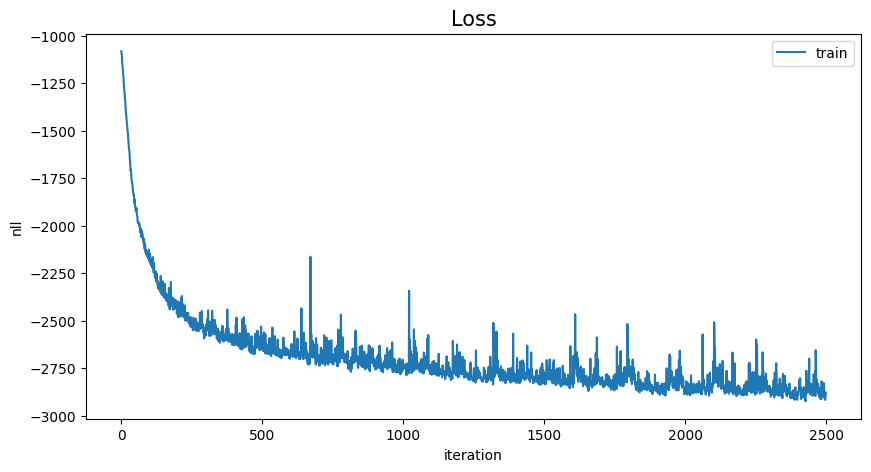

In [62]:
# view training
loss_history = np.array(loss_history).reshape(-1)
x = range(loss_history.shape[0])
plt.figure(figsize=(10, 5))
plt.plot(x, loss_history, label="train")
plt.title("Loss", fontsize=15)
plt.legend(loc="upper right")
plt.xlabel("iteration")
plt.ylabel("nll")
plt.show()

## Inference

At inference time, it's recommended to use the `generate()` method for autoregressive generation, similar to NLP models.

Forecasting involves getting data from the test instance sampler, which will sample the very last `context_length` sized window of values from each time series in the dataset, and pass it to the model. Note that we pass `future_time_features`, which are known ahead of time, to the decoder.

The model will autoregressively sample a certain number of values from the predicted distribution and pass them back to the decoder to return the prediction outputs:

In [53]:
model.eval()

forecasts_ = []

for batch in test_dataloader:
    outputs = model.generate(
        static_categorical_features=batch["static_categorical_features"].to(device)
        if config.num_static_categorical_features > 0
        else None,
        static_real_features=batch["static_real_features"].to(device)
        if config.num_static_real_features > 0
        else None,
        past_time_features=batch["past_time_features"].to(device),
        past_values=batch["past_values"].to(device),
        future_time_features=batch["future_time_features"].to(device),
        past_observed_mask=batch["past_observed_mask"].to(device),
    )
    forecasts_.append(outputs.sequences.cpu().numpy())

The model outputs a tensor of shape (`batch_size`, `number of samples`, `prediction length`, `input_size`). 

In this case, we get `100` possible values for the next `48` hours for each of the `862` time series (for each example in the batch which is of size `1` since we only have a single multivariate time series):

In [54]:
forecasts_[0].shape

(1, 100, 48, 862)

We'll stack them vertically, to get forecasts for all time-series in the test dataset (just in case there are more time series in the test set):

In [55]:
forecasts = np.vstack(forecasts_)
print(forecasts.shape)

(1, 100, 48, 862)


We can evaluate the resulting forecast with respect to the ground truth out of sample values present in the test set. For that, we'll use the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library, which includes the [MASE](https://huggingface.co/spaces/evaluate-metric/mase) and [sMAPE](https://huggingface.co/spaces/evaluate-metric/smape) metrics.

We calculate both metrics for each time series variate in the dataset:

In [56]:
from evaluate import load
from gluonts.time_feature import get_seasonality

mase_metric = load("evaluate-metric/mase")
smape_metric = load("evaluate-metric/smape")

forecast_median = np.median(forecasts, 1).squeeze(0).T

mase_metrics = []
smape_metrics = []

for item_id, ts in enumerate(test_dataset):
    training_data = ts["target"][:-prediction_length]
    ground_truth = ts["target"][-prediction_length:]
    mase = mase_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
        training=np.array(training_data),
        periodicity=get_seasonality(freq),
    )
    mase_metrics.append(mase["mase"])

    smape = smape_metric.compute(
        predictions=forecast_median[item_id],
        references=np.array(ground_truth),
    )
    smape_metrics.append(smape["smape"])

In [57]:
print(f"MASE: {np.mean(mase_metrics)}")

MASE: 1.1913437728068093


In [58]:
print(f"sMAPE: {np.mean(smape_metrics)}")

sMAPE: 0.5322665081607634


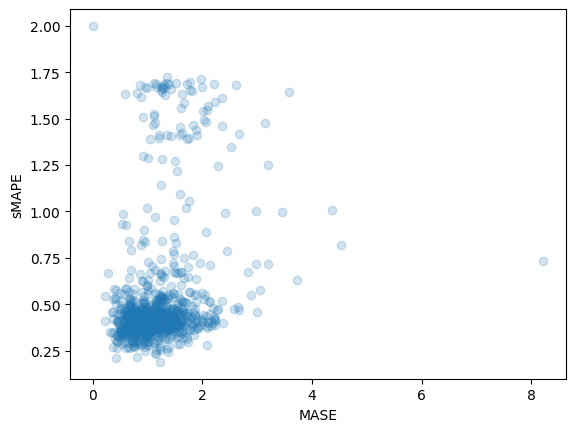

In [59]:
plt.scatter(mase_metrics, smape_metrics, alpha=0.2)
plt.xlabel("MASE")
plt.ylabel("sMAPE")
plt.show()

To plot the prediction for any time series variate with respect the ground truth test data we define the following helper:

In [76]:
import matplotlib.dates as mdates


def plot(ts_index, mv_index):
    fig, ax = plt.subplots()

    index = pd.period_range(
        start=multi_variate_test_dataset[ts_index][FieldName.START],
        periods=len(multi_variate_test_dataset[ts_index][FieldName.TARGET]),
        freq=multi_variate_test_dataset[ts_index][FieldName.START].freq,
    ).to_timestamp()

    ax.xaxis.set_minor_locator(mdates.HourLocator())

    ax.plot(
        index[-2 * prediction_length :],
        multi_variate_test_dataset[ts_index]["target"][
            mv_index, -2 * prediction_length :
        ],
        label="actual",
    )

    ax.plot(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(axis=0),
        label="mean",
    )
    ax.fill_between(
        index[-prediction_length:],
        forecasts[ts_index, ..., mv_index].mean(0)
        - forecasts[ts_index, ..., mv_index].std(axis=0),
        forecasts[ts_index, ..., mv_index].mean(0)
        + forecasts[ts_index, ..., mv_index].std(axis=0),
        alpha=0.2,
        interpolate=True,
        label="+/- 1-std",
    )
    ax.legend()
    fig.autofmt_xdate()

For example:

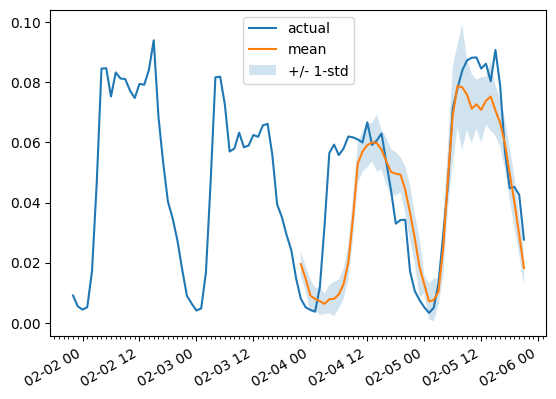

In [77]:
plot(0, 344)

## Conclusion

How do we compare against other models? The [Monash Time Series Repository](https://forecastingdata.org/#results) has a comparison table of test set MASE metrics which we can add to:

|Dataset | 	SES| 	Theta | 	TBATS| 	ETS	| (DHR-)ARIMA| 	PR|	CatBoost |	FFNN	| DeepAR | 	N-BEATS | 	WaveNet|  Transformer (uni.) | **Informer (mv.)**| Informer (uni.) | Autoformer (uni.) | D-Linear |
|:------------------:|:-----------------:|:--:|:--:|:--:|:--:|:--:|:--:|:---:|:---:|:--:|:--:|:--:|:--:| :--:| :--:| :--:| 
|Traffic Hourly | 1.922	| 1.922	| 2.482 |	2.294|	2.535|	1.281|	1.571	|0.892|	0.825	|1.100|	1.066	| **0.821** | 1.191 | 0.883 | 0.826 | 0.970 |

As can be seen, and perhaps surprising to some, the multivariate forecasts are typically _worse_ than the univariate ones, the reason being the difficulty in estimating the cross-series correlations/relationships. The additional variance added by the estimates often harms the resulting forecasts or the model learns spurious correlations. We refer to [this paper](https://openreview.net/forum?id=GpW327gxLTF) for further reading. Multivariate models tend to work well when trained on a lot of data.

So the vanilla Transformer still performs best here! In the future, we hope to better benchmark these models in a central place to ease reproducing the results of several papers. Stay tuned for more!

## Resources

We recommend to check out the [Informer docs](https://huggingface.co/docs/transformers/main/en/model_doc/informer) and the example notebook linked at the top of this blog post.